## **STEP 0 - SETTING UP THE ENVIRONMENT**

In [1]:
# import generic modules
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

try:
  import py3Dmol
except:
  !pip install py3Dmol
  import py3Dmol

In [2]:
#connect colab to Google Drive
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [3]:
# go to your drive (we don't need to create it, since the folder should already exist from yesterday!)
%cd /content/drive/MyDrive/cecam_school_2024
# check the path of the folder
%pwd
# save path to a local variable, will be useful later
path = %pwd

/content/drive/MyDrive/cecam_school_2024


In [3]:
#now that we are connected to drive, we can import simplemd (that should already be in the folder and set to be used)
import simplemd

## **EXERCISE: MELTING AND HYSTERESIS**

  1. Perform simulations of a Lennard Jones crystal with 864 particles (REMEMBER when you create the crystal with the method generate_lattice in simplemd, you input the number N of CELLS, not of particles, which will be $ N_{particles} = 4N^3$) at different temperatures from 0.1 to 3.0. The temperature can be controlled using the Langevin Thermostat. What happens to the crystal
  as temperature increases?

  2. Compute the average total energy at different temperatures. How does the energy depend on the temperature?<p>
   Also compute the heat capacity
  of the system for different temperatures. (**HINT: the heat capacity can be computed as $C_v = \frac{(< E^2 >\; −\; < E >^2)}{T^2} $**)

  3. Repeat points (1) and (2) starting from a structure that has been equilibrated for a long time at T=3 (**HINT: simpleMD writes the final coordinates on a file. You can run a simulation at T=3 and save the final positions. You should start from that configuration!**).
  Are the average energy and the heat capacity the same as in the previous points of the exercise? For which temperatures do you observe more difference?




In [20]:
Ts = np.arange(0.1,3.1,0.1) #save the temperatures in an array

In [27]:
cell,positions = simplemd.generate_lattice(6) #first I generate the lattice with 4*N^3 = 864 particles
for T in Ts: #run a loop over temperatures
  keys={
  'temperature': T,
  'friction':1,
  'tstep':0.01,
  'forcecutoff': 2.5,
  'listcutoff': 3.0,
  'nstep': 10000,
  'nconfig': 10,
  'nstat': 10,
  'cell': cell,
  'positions': positions,
  'wrapatoms': True
  }

  smd = simplemd.SimpleMD(**keys)
  smd.run()
  np.save(path+"/statistics_T%.1f.npy"%T,smd.statistics) #and save them in a file

100%|██████████| 10000/10000 [00:24<00:00, 410.83it/s]


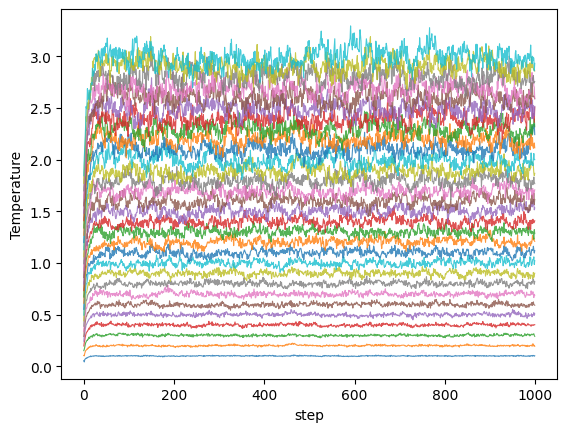

In [21]:
#check if the thermostat is working!

fig, ax = plt.subplots()
for T in Ts:
  data = np.load(path+"/statistics_T%.1f.npy"%T)
  ax.plot(data.T[2],alpha=0.8,lw=0.8)
ax.set_xlabel('step')
ax.set_ylabel('Temperature')
plt.show()

In [22]:
#run a short simulation just to visualize the trajectories (py3Dmol crashes with too many frames)
for T in [0.1,0.5,0.6,3]:

  keys={
  'temperature': T,
  'friction':1,
  'tstep':0.01,
  'forcecutoff': 2.5,
  'listcutoff': 3.0,
  'nstep': 10000,
  'nconfig': 100,
  'nstat': 1000,
  'cell': cell,
  'positions': positions,
  'wrapatoms': True
  }

  smd = simplemd.SimpleMD(**keys)
  smd.run()
  simplemd.write_trajectory(path+"/trajectory_T%s.xyz"%T, smd.trajectory)

100%|██████████| 10000/10000 [00:23<00:00, 427.68it/s]


In [23]:
#visualize the trajectories only for the chosen temperatures
for T in [0.1,0.5,0.6,3]:
  with open(path+"/trajectory_T%s.xyz"%T) as f:
      traj_xyz = f.read()

  view = py3Dmol.view(width=400, height=300)
  view.addModelsAsFrames(traj_xyz, "xyz")
  view.setStyle({"sphere": {"radius":0.4}})
  view.animate({'loop': "forward"})
  view.zoomTo()
  view.show()

Output hidden; open in https://colab.research.google.com to view.

In [24]:
#evaluate from the statistics, the mean energy and the specific heat

cvs = []
ens = []

for T in Ts:
  data = np.load(path+"/statistics_T%.1f.npy"%T).T[:,50:]
  ens.append(np.mean(data[4]))
  cvs.append((np.mean(data[4]**2) - np.mean(data[4])**2)/T**2)

Text(0, 0.5, 'Total energy')

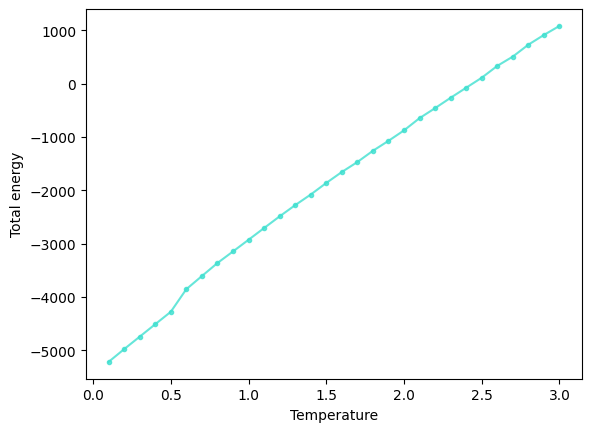

In [27]:
plt.plot(ts,ens,'.-',c='turquoise',alpha=0.8)
plt.xlabel('Temperature')
plt.ylabel('Total energy')


Text(0, 0.5, '$C_v$')

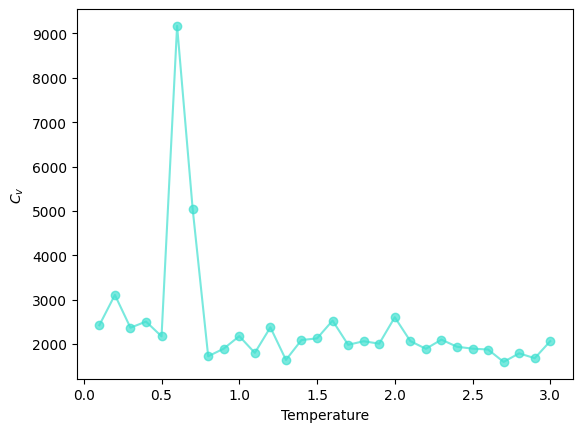

In [34]:
plt.plot(ts,cvs,'o-',c='turquoise',alpha=0.7)
plt.xlabel('Temperature')
plt.ylabel('$C_v$')

## (3) Run a long simulation at T=3 and repeat steps (1) and (2)

In [35]:
#run a simulation with the same parameters and save the final position in a file

keys={
'temperature': 3,
'friction':1,
'tstep':0.01,
'forcecutoff': 2.5,
'listcutoff': 3.0,
'nstep': 200000,
'nconfig': 10,
'nstat': 10,
'cell': cell,
'positions': positions,
'wrapatoms': True
}

smd = simplemd.SimpleMD(**keys)
smd.run()
np.save(path+"/final_position.npy",smd.positions)

100%|██████████| 200000/200000 [08:22<00:00, 398.40it/s]


In [36]:
#upload the initial position from the last frame of this simulation

positions_start = np.load(path + '/final_position.npy')

### and repeat the steps starting from there

In [37]:
#run again the loop over the temperatures, starting from a different position

for T in Ts: #run a loop over temperatures
  keys={
  'temperature': T,
  'friction': 1,
  'tstep':0.01,
  'forcecutoff': 2.5,
  'listcutoff': 3.0,
  'nstep': 10000,
  'nconfig': 10,
  'nstat': 10,
  'cell': cell,
  'positions': positions_start,
  'wrapatoms': True
  }

  smd = simplemd.SimpleMD(**keys)
  smd.run()
  np.save(path+"/statistics_T%.1f_from3.npy"%T,smd.statistics)

100%|██████████| 10000/10000 [00:24<00:00, 412.25it/s]


In [28]:
#evaluate the mean energy and specific heat for the new set of simulations

cvs_f3 = []
ens_f3 = []
for T in Ts:
  data = np.load(path+"/statistics_T%.1f_from3.npy"%T).T[:,50:]
  ens_f3.append(np.mean(data[4]))
  cvs_f3.append((np.mean(data[4]**2) - np.mean(data[4])**2)/T**2)

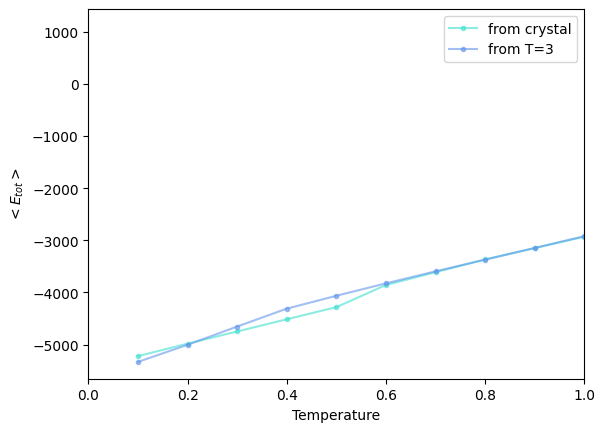

In [29]:
plt.plot(Ts,ens,'.-',label='from crystal',c='turquoise',alpha=0.6)
plt.plot(Ts,ens_f3,'.-',label='from T=3',c='cornflowerblue',alpha=0.6)
plt.xlabel('Temperature')
plt.ylabel('$<E_{tot}>$')
plt.xlim((0,1))
plt.legend()

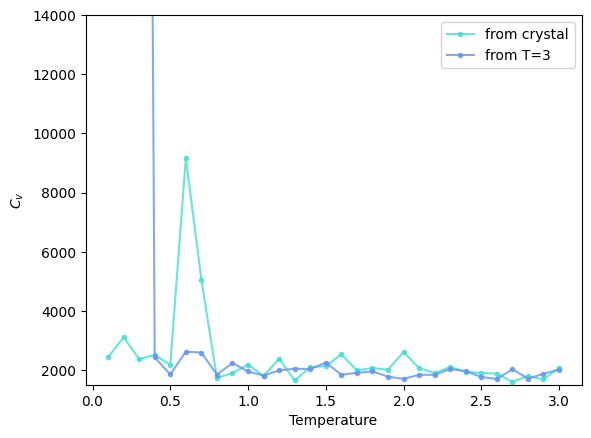

In [50]:
plt.plot(Ts,cvs,'.-',label='from crystal',c='turquoise',alpha=0.8)
plt.plot(Ts,cvs_f3,'.-',label='from T=3',c='cornflowerblue',alpha=0.8)
plt.xlabel('Temperature')
plt.ylabel('$C_v$')
plt.ylim((1500,14000))
plt.legend()

In [38]:
#run a short simulation to see what happens at T=0.1

cell,position = simplemd.generate_lattice(6)
T=0.01
keys={
'temperature': T,
'friction': 1,
'tstep':0.01,
'forcecutoff': 2.5,
'listcutoff': 3.0,
'nstep': 200000,
'nconfig': 500,
'nstat': 10000,
'cell': cell,
'positions': positions_start,
'wrapatoms': True
}

smd = simplemd.SimpleMD(**keys)
smd.run()
simplemd.write_trajectory(path+"/trajectory_T%.1f_f3.xyz"%T, smd.trajectory)

100%|██████████| 20000/20000 [00:41<00:00, 481.82it/s]


In [39]:
with open(path+"/trajectory_T%.1f_f3.xyz"%T) as f:
    traj_xyz = f.read()

view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(traj_xyz, "xyz")
view.setStyle({"sphere": {"radius":0.4}})
view.animate({'loop': "forward"})
view.zoomTo()
view.show()

Output hidden; open in https://colab.research.google.com to view.

# Bonus Exercise
1. Modify the function compute forces in simpleMD to simulate a GEM4
fluid. The new potential is given by:<p>
<center> $V(r) = exp(−r^4)$</center><left><p>
and the force is given by:
<center>$\vec{F}(\vec{x}) = 4x^2\;\vec{x}\; exp(-x^4)$</center>
<p>

2. Equilibrate 300 particles in a cubic box of size 3 starting from a random
configuration at T=0.1. What happens to the system at low temperature? Is this the same phase one finds in the Lennard Jones fluid?
3. Build a phase diagram of the GEM4 fluid by changing the temperature
and the box size (**HINT**: you can find the approximate position of
the transition line by looking at the heat capacity dependence on the
temperature at fixed volume).

In [4]:
cell = (3,3,3)
positions= np.random.random((300,3))*cell[0]

T = 0.5
#for i,T in enumerate(Ts): #run a loop over temperatures
keys={
'wrapatoms' : True,
'temperature': T,
'friction':1,
'tstep':0.01,
'forcecutoff': 2.5,
'listcutoff': 3.0,
'nstep': 10000,
'nconfig': 100,
'nstat': 10,
'cell': cell,
'positions' : positions
}

smd = simplemd.SimpleMD(**keys)
smd.run()
np.save(path+"/statistics_GEM4T%.1f.npy"%T,smd.statistics)
simplemd.write_trajectory(path+"/trajectory_GEM4T%.1f.xyz"%T, smd.trajectory)

TypeError: __init__() got an unexpected keyword argument 'wrapatoms'

In [72]:
with open(path+"/trajectory_GEM4T%.1f.xyz"%T) as f:
    traj_xyz = f.read()

view = py3Dmol.view(width=400, height=300)
view.addModelsAsFrames(traj_xyz, "xyz")
view.setStyle({"sphere": {"radius":0.1}})
view.animate({'loop': "forward"})
view.zoomTo()
view.show()

Output hidden; open in https://colab.research.google.com to view.

In [46]:
Ts = np.arange(0.1,3.2,0.2)
sizes = print(np.arange(3,6,0.5))

for T in (Ts): #run a loop over temperatures
  for s in sizes:
    cell = (s,s,s)
    positions= np.random.random((300,3))*s

    keys={
    'wrapatoms' : True,
    'temperature': T,
    'friction':1,
    'tstep':0.01,
    'forcecutoff': 2.5,
    'listcutoff': 3.0,
    'nstep': 10000,
    'nconfig': 10000,
    'nstat': 10,
    'cell': cell,
    'positions' : positions
    }

    smd = simplemd.SimpleMD(**keys)
    smd.run()
    np.save(path+"/statistics_GEM4T%.1f_s%.1f.npy"%(T,s),smd.statistics)

100%|██████████| 10000/10000 [00:11<00:00, 864.26it/s]


In [55]:
CV = {}
E = {}
for s in sizes:
  cvs_gem4 = []
  ens = []
  for T in Ts:
    data = np.load(path+"/statistics_GEM4T%.1f_s%.1f.npy"%(T,s)).T[:,50:]
    ens.append(np.mean(data[4]))
    cvs_gem4.append((np.mean(data[4]**2) - np.mean(data[4])**2)/T**2)
  CV[s] = np.array(cvs_gem4)
  E[s] = np.array(ens)

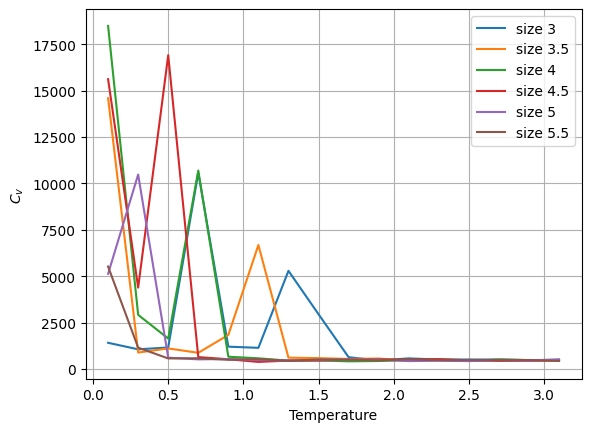

In [62]:
for s in sizes:
  plt.plot(Ts,CV[s],label='size %s'%s)
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('$C_v$')
#plt.ylim((0,3000))
plt.grid()
plt.show()


In [63]:
transitions = [1.3,1.1,0.7,0.5,0.3,0.1]

Text(0.5, 1.0, 'Phase diagram')

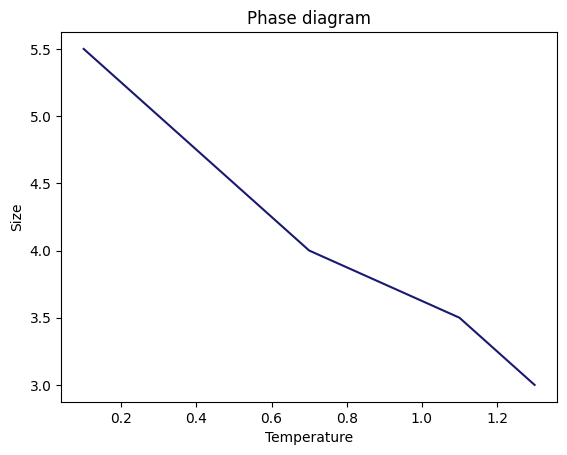

In [68]:
plt.plot(transitions,sizes,c='midnightblue')
plt.xlabel('Temperature')
plt.ylabel('Size')
plt.title('Phase diagram')